# 1.6:  Uncertainty estimation with the bootstrap#

*Andrew Valentine & Malcolm Sambridge - Research School of Earth Sciences, The Australian National University - Last updated Sept. 2019*

This practical explores the use of the Bootstrap method for uncertainty estimation. Recall that both linear theory error estimation as well as Monte Carlo error propagation required nowledge of the size of the data errors in the form of a data covariance matrix.   The bootstrap can be used to estimate error in a solution without knowledge of  size of errors in the data. Instead it can be applied by assuming that the data errors, or data residuals more usually, are independently, identically distributed, IID. This can be a reasonable assumption if data error correlation is minimal.

<img src="Figures/ballistics.png" alt="Cannonball figure" width="600"/>
Cannonball heights as a function of time.


A cannon ball is fired directly upwards from an unknown starting height
above the surface, $m_1$, with unknown initial velocity, $m_2$ and
unknown gravitational acceleration, $m_3$ . Newton’s laws of motion tell
us that the relationship between position and time follows

$$ y(t) = m_1 + m_2t -\frac{1}{2}m_3t^2.
\label{eq:cannon} $$

An experiment has been performed and heights, $y_i$, $(i=1,\dots,8)$ are
collected at fixed time intervals of a second. We obtain the data
$y = [26.94, 33.45, 40.72 , 42.32, 44.30 , 47.19 , 43.33 , 40.13 ]$,
$t = [1.0,2.0,\dots,8.0]$.

First load some libraries.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math
import pickle
from inversionCourse import plotcovellipse as pc

To find the unknowns $(m_1, m_2, m_3)$ we must fit a quadratic curve
(as above) to the observed data (see figure 2). This can be achieved
by solving the linear system ${\bf d} = G{\bf m}$, where ${\bf d}$ is
the data, ${\bf m}$ is the vector of unknowns and $G$ is the matrix
connecting the two, determined by the expression above. The solution to this is
in your course exercise, but is equivalent to evaluating the expression

$${\bf m} = (G^TG)^{-1} G^T {\bf d}
\label{eq:LS}$$

All terms on the right hand side of this equation are known and so
its a simple case of plugging in values to determine the best fit
estimates of $(m_1, m_2, m_3)$.

**Task 1:** Calculate the best fit values of the three unknowns (height, velocity
and gravitational acceleration). We call these values
$(m_1^0, m_2^0, m_3^0)$ our <span>**solution**</span>. Can you guess
where this experiment took place?

 Least squares solution
 [ 17.61607143  10.00761905   1.79238095]


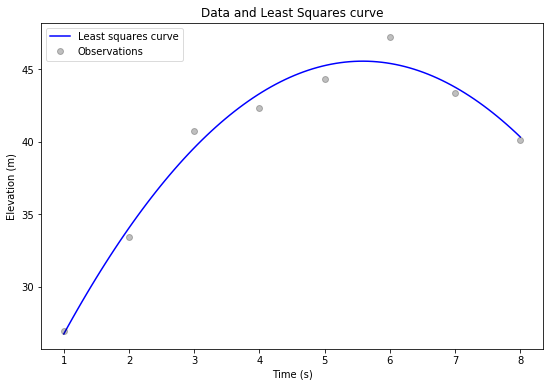

[[  1.    1.   -0.5]
 [  1.    2.   -2. ]
 [  1.    3.   -4.5]
 [  1.    4.   -8. ]
 [  1.    5.  -12.5]
 [  1.    6.  -18. ]
 [  1.    7.  -24.5]
 [  1.    8.  -32. ]]


In [3]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

yobs = [26.94, 33.45, 40.72, 42.32, 44.30, 47.19, 43.33, 40.13]
t = np.linspace(1.0,8.0,len(yobs))
G = np.transpose([np.ones(len(t)), t, -0.5*t*t,]) # G matrix

sol = np.dot(np.linalg.inv(np.dot(np.transpose(G), G)), np.dot(np.transpose(G),yobs)) # Least squares solution 
 
print(' Least squares solution\n',sol)

t_fine = np.linspace(1.0,8.0,100)
G_fine = np.transpose([np.ones(len(t_fine)), t_fine, -0.5*t_fine*t_fine,]) # G matrix

ypredicted = np.dot(G_fine,sol) # predicted y values from least squares solution

# ----------------------------------------------------------------------------   
# plot data and least squares solution
# ----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(9,6))

ax.plot(t_fine, ypredicted,label='Least squares curve',color='b')
ax.plot(t,yobs,'o',color=(0, 0, 0, 0.25),label='Observations')
plt.legend(loc='upper left',framealpha=0.7)
plt.title('Data and Least Squares curve')
plt.xlabel('Time (s)')
plt.ylabel('Elevation (m)')
plt.show()
print(G)


The problem now is to use the <span>**bootstrap**</span> to determine
how error in the data propagate into the estimated unknowns. We do not
know the size of errors in the data but we can apply the bootstrap.
Since the data are associated with increasing time it does not make
sense to directly resample the data (because we could end up with two
heights of the same value associated with different times). The data are
not IID, since they belong to a trend. However we can still proceed by
applying the bootstrap principle to the data residuals produced by the
best fit solution., i.e. we have 8 residuals, $r_i$, where

$$r_i = y_i - m^0_1 - m^0_2t_i +\frac{1}{2}m^0_3t_i^2.\quad (i=1,\dots, 8).$$

If we assume that the residuals are IID they can be re-sampled with
replacement in the usual way to form multiple sets of 8 residual values
$r^*_j, (j=1,\dots,8)$ and new bootstrap data are constructed using this
set of residuals by

$$y^*_j = r^*_j + m^0_1 + m^0_2t_j -\frac{1}{2}m^0_3t_j^2.\quad (j=1,\dots, 8).$$

Using this approach the residuals are mixed between different data, and
so each y values does not simply get its own residual back.

**Task 2:**  Write a python script to build bootstrap data sets and
for each of these calculate
the bootstrap estimates of the unknowns. Lets call these
$(m_1^i, m_2^i, m_3^i), (i=1,\dots, B)$. The number of bootstrap samples
$B$ is your choice but it should be at least 100.

It can be instructive to <span>**plot the bootstrap samples**</span> as
a scatter plot for the three pair of variables, i.e. $(m^i_1, m^i_2)$,
$(m^i_2, m^i_3)$ and $(m^i_1, m^i_3)$, $(i=1,\dots, B)$. They should
look something like the Figure below.

<img src="Figures/bootstrap.png" alt="Bootstrap figure" width="400"/>
Bootstrap solutions and confidence ellipses distributed about the best fit solution.

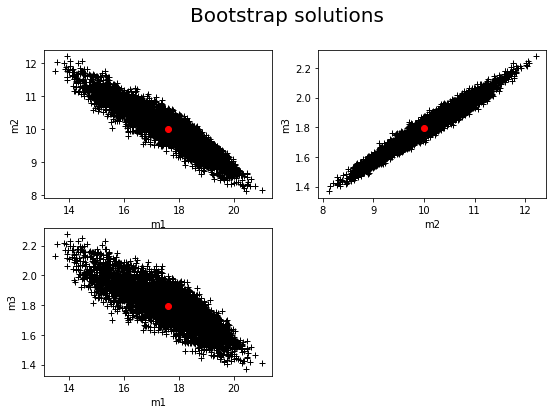

[ 17.61607143  10.00761905   1.79238095]


In [4]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

nBoot = 5000 # Number of bootstrap samples
res = np.dot(G,sol)-yobs # residuals of least squares solution
solBoot = np.zeros((nBoot,np.shape(G)[1]))
for i in range(nBoot):
    yBoot = yobs + np.random.choice(res,size=len(res),replace=True) # random sample residuals with replacement
    solBoot[i] = np.dot(np.linalg.inv(np.dot(np.transpose(G), G)), np.dot(np.transpose(G),yBoot)) # Least squares solution 

fig = plt.figure(figsize=(9,6))
fig.suptitle("Bootstrap solutions", fontsize=20)

ax1 = plt.subplot("221")
xp, yp = solBoot.T[0], solBoot.T[1]
ax1.plot(xp, yp, 'k+')
ax1.plot(sol[0],sol[1], 'ro')
#ax1.set_xlim(mls[0]-1.3*1.96*sig_param1,mls[0]+1.3*1.96*sig_param1)
#ax1.set_ylim(mls[1]-1.3*1.96*sig_param2,mls[1]+1.3*1.96*sig_param2)
ax1.set_xlabel('m1')
ax1.set_ylabel('m2')

ax2 = plt.subplot("222")
xp, yp =  solBoot.T[1], solBoot.T[2]
ax2.plot(xp, yp, 'k+')
ax2.plot(sol[1],sol[2], 'ro')
#ax2.set_xlim(mls[1]-1.3*1.96*sig_param2,mls[1]+1.3*1.96*sig_param2)
#ax2.set_ylim(mls[2]-1.3*1.96*sig_param3,mls[2]+1.3*1.96*sig_param3)
ax2.set_xlabel('m2')
ax2.set_ylabel('m3')

ax3 = plt.subplot("223")
xp, yp =  solBoot.T[0], solBoot.T[2]
ax3.plot(xp, yp, 'k+')
ax3.plot(sol[0],sol[2], 'ro')
#ax3.set_xlim(mls[0]-1.3*1.96*sig_param1,mls[0]+1.3*1.96*sig_param1)
#ax3.set_ylim(mls[2]-1.3*1.96*sig_param3,mls[2]+1.3*1.96*sig_param3)
ax3.set_xlabel('m1')
ax3.set_ylabel('m3')

plt.show()
print(sol)

**Task 3:** From the bootstrap output samples
$(m_1^i, m_2^i, m_3^i), (i=1,\dots, B)$ calculate the i) <span>**the mean**</span>, ii) <span>**the
variance**</span>, iii) <span>**the bias corrected solution**</span>,
and iv) <span>**the 95% confidence intervals**</span> for each of the
three unknowns. The bias correction is the mean of the differences between each Bootstrap solution and the estimator itself, which in this case is the best fit solution. This is subtracted from the best fit to produce the  <span>**the bias corrected solution**</span>.

The mean should look similar to the best fit values and
the bias should be small. The variance and confidence intervals
characterize the error in the estimated values of the unknowns.



In [6]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

# Bootstrap mean
print(' Bootstrap mean solution           ',np.mean(solBoot,axis=0))
print(' Bootstrap variance                ',np.var(solBoot,axis=0))
bcsol = sol - (np.mean(solBoot,axis=0)-sol)
print(' Bootstrap bias corrected solution ',bcsol)
p = np.percentile(solBoot,[2.5,97.5],axis=0)
print(' Bootstrap 95% Confidence intervals: ')
print(" Parameter 1 {:7.3f} [{:7.3f}, {:7.3f}]".format(bcsol[0],p[0,0],p[1,0]))
print(" Parameter 2 {:7.3f} [{:7.3f}, {:7.3f}]".format(bcsol[1],p[0,1],p[1,1]))
print(" Parameter 3 {:7.3f} [{:7.3f}, {:7.3f}]".format(bcsol[2],p[0,2],p[1,2]))


 Bootstrap mean solution            [ 17.62103005  10.00082468   1.79053818]
 Bootstrap variance                 [ 1.68358374  0.42783967  0.01997262]
 Bootstrap bias corrected solution  [ 17.6111128   10.01441342   1.79422372]
 Bootstrap 95% Confidence intervals: 
 Parameter 1  17.611 [ 14.867,  19.754]
 Parameter 2  10.014 [  8.787,  11.330]
 Parameter 3   1.794 [  1.529,   2.075]
